In [15]:
import os
# import tomopy
# import numpy as np
import matplotlib.pyplot as plt
import sys
import numpy as np
import discorpy.losa.loadersaver as losa
import discorpy.prep.preprocessing as prep
import discorpy.proc.processing as proc
import discorpy.post.postprocessing as post
root_folder = os.path.dirname(os.getcwd())
sys.path.append(root_folder)
import utilities as rocku
import skimage as ski
# import dxchange
# import algotom.io.loadersaver as losa
# import algotom.prep.correction as corr
# import algotom.io.converter as conv
# import algotom.prep.calculation as calc
# import algotom.rec.reconstruction as rec
# import bm3d_streak_removal as bm3d
# import h5py as h5f
# from tqdm import tqdm
# import timeit
import multiprocessing as mp
# import svmbir
# import ast
# from pprint import pprint
# from skimage.measure import profile_line
# %matplotlib notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower
ncore = mp.cpu_count()
print("CPU cores:", ncore)

CPU cores: 256


# Workflow starts here!

In [5]:
###################### need to change start
instrument = "/HFIR/CG1D"
ipts="30008"
###################### need to change end

In [8]:
data_loc = instrument + "/IPTS-"+ipts+"/raw/alignment_calibration/2025_07_07_grid_Marana_11/"
sorted(os.listdir(data_loc))

['grid_010ms_0000_0013.tiff',
 'grid_010ms_0000_0014.tiff',
 'grid_010ms_0000_0015.tiff',
 'grid_0200ms_0000_0011.tiff',
 'grid_020ms_0000_0012.tiff',
 'test_0000_0007.tiff',
 'test_0000_0008.tiff',
 'test_0000_0009.tiff',
 'test_0000_0010.tiff',
 'test_0001_0005.tiff',
 'test_0001_0006.tiff']

In [19]:
# Initial parameters
data_name = "grid_010ms_0000_0015"
data_path = data_loc + data_name + ".tiff"
num_coef = 5  # Number of polynomial coefficients
mat0 = losa.load_image(data_path) # Load image
(height, width) = mat0.shape

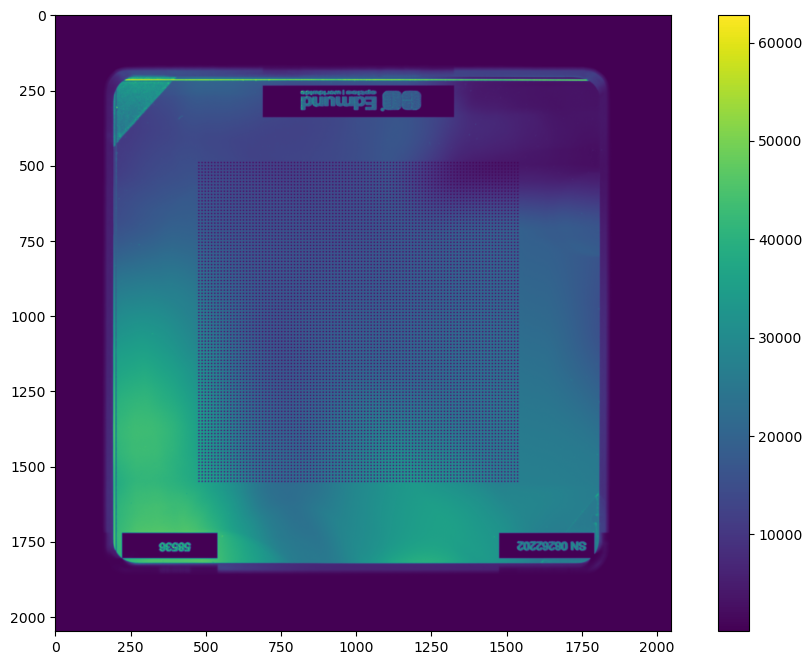

In [20]:
plt.imshow(mat0)
plt.colorbar()
plt.show()

Text(0.5, 1.0, 'After subtraction')

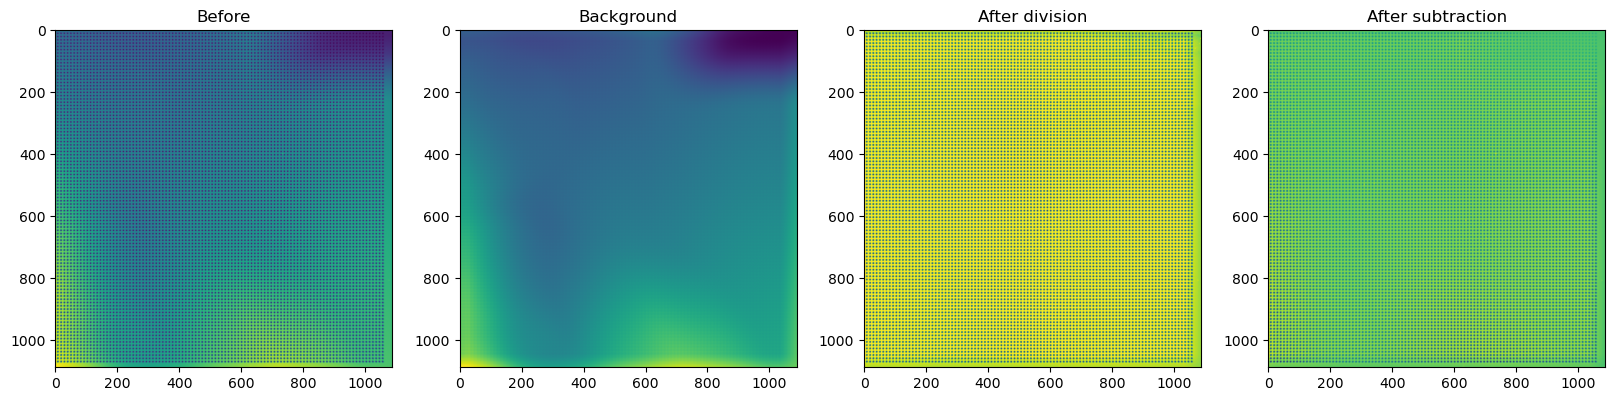

In [39]:
crop = True
# crop = False
crop_left = 480#320
crop_right = -480#1080
crop_top = 480
crop_bottom = -480
###################### need to change end
mat_crop = rocku.crop(mat0, crop_left, crop_right, crop_top, crop_bottom, crop)
bkgd = ski.filters.gaussian(mat_crop, sigma=30, truncate=1)
img_bg_div = mat_crop/bkgd
img_bg_sub = mat_crop-bkgd
# img_bg_sub = img_bg_sub*(1/img_bg_sub.max())
f, ax = plt.subplots(1, 4, figsize=(20, 9))
ax[0].imshow(mat_crop)#, vmax=0.2, vmin=0)
ax[0].set_title('Before')
ax[1].imshow(bkgd)#, vmax=0.2, vmin=0)
ax[1].set_title('Background')
ax[2].imshow(img_bg_div, vmax=1.2, vmin=0)
ax[2].set_title('After division')
ax[3].imshow(img_bg_sub, )#vmax=1.2, vmin=0)
ax[3].set_title('After subtraction')

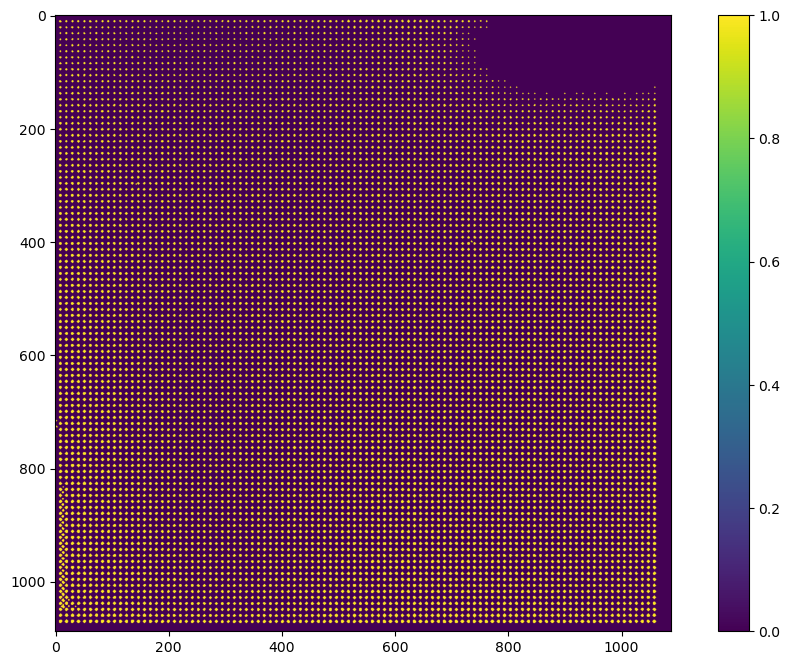

In [40]:
# Segment dots
mat1 = prep.binarization(img_bg_sub)
plt.imshow(mat1)
plt.colorbar()
plt.show()

Horizontal slope: 0.0002853408329333848. Vertical slope -0.00020486166550255349


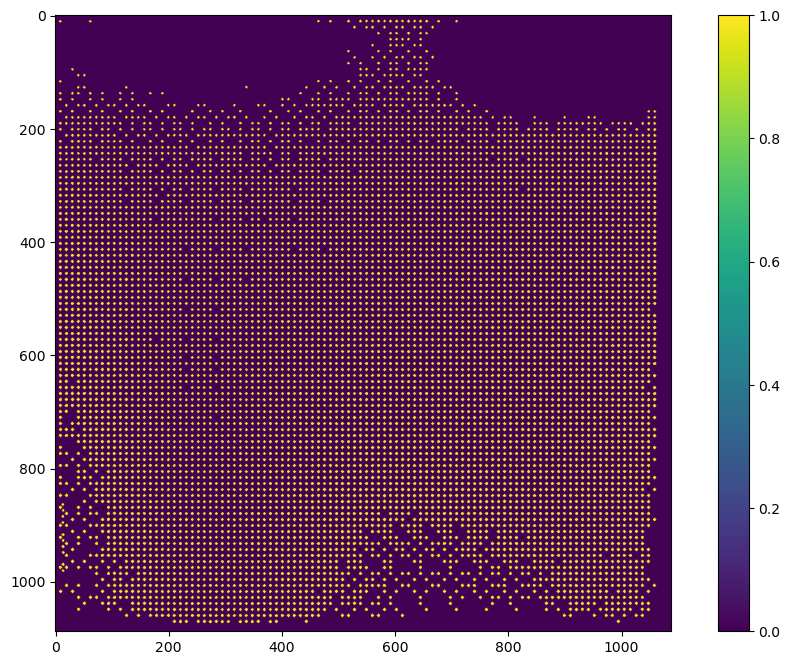

In [41]:
# Segment dots
# mat1 = prep.binarization(mat0)
# Calculate the median dot size and distance between them.
(dot_size, dot_dist) = prep.calc_size_distance(mat1)
# Remove non-dot objects
mat1 = prep.select_dots_based_size(mat1, dot_size)
# Remove non-elliptical objects
mat1 = prep.select_dots_based_ratio(mat1)
# losa.save_image(output_base + "/segmented_dots.jpg", mat1) # Save image for checking
# Calculate the slopes of horizontal lines and vertical lines.
hor_slope = prep.calc_hor_slope(mat1)
ver_slope = prep.calc_ver_slope(mat1)
print("Horizontal slope: {0}. Vertical slope {1}".format(hor_slope, ver_slope))
plt.imshow(mat1)
plt.colorbar()
plt.show()

In [37]:
# Group points to horizontal lines
list_hor_lines = prep.group_dots_hor_lines(mat1, hor_slope, dot_dist)
# Group points to vertical lines
list_ver_lines = prep.group_dots_ver_lines(mat1, ver_slope, dot_dist)
# Optional: remove horizontal outliers
list_hor_lines = prep.remove_residual_dots_hor(list_hor_lines, hor_slope)
# Optional: remove vertical outliers
list_ver_lines = prep.remove_residual_dots_ver(list_ver_lines, ver_slope)
# Save output for checking
# losa.save_plot_image(output_base + "/horizontal_lines.png", list_hor_lines, height, width)
# losa.save_plot_image(output_base + "/vertical_lines.png", list_ver_lines, height, width)


# Export HDF5

In [17]:
output_hdf5_dir = instrument + "/IPTS-"+ipts+"/shared/autoreduce/hdf5/"
output_hdf5 = output_hdf5_dir + save_name_str + '_BH_corr.h5'
print(output_hdf5)

/HFIR/CG1D/IPTS-32328/shared/autoreduce/hdf5/2024_03_11_3D_stage2_424proj_gridrec_BH_corrected_BH_corr.h5


In [18]:
with h5f.File(output_hdf5, mode='a') as f:
    f.create_group('tomo/recon')
    f.create_dataset('tomo/recon/recon_volume_BH', data=recon)
    f.create_dataset('tomo/recon/history', data=(str(history_dict),))